In [70]:
import os
import numpy as np

Ucitavanje dataseta

In [ ]:
#dataset = api.load('text8')

In [93]:
with open ('text8', 'r') as f:
    all_words = f.read().split()
    sample = all_words[:20000]

Uzimanje privh 1000 reci kao sample, 
Pravljenje vokabulara i njegovog inverza.
{'anarchism': 0, 'originated': 1...}
{0: 'anarchism', 1: 'originated'...}

In [94]:
import collections

count = collections.Counter(sample)

vocab = {}
inverse_vocab = {}

for word in count:
    vocab[word] = len(vocab)
    inverse_vocab[len(inverse_vocab)] = word
 
print(vocab)
print(inverse_vocab)

{'anarchism': 0, 'originated': 1, 'as': 2, 'a': 3, 'term': 4, 'of': 5, 'abuse': 6, 'first': 7, 'used': 8, 'against': 9, 'early': 10, 'working': 11, 'class': 12, 'radicals': 13, 'including': 14, 'the': 15, 'diggers': 16, 'english': 17, 'revolution': 18, 'and': 19, 'sans': 20, 'culottes': 21, 'french': 22, 'whilst': 23, 'is': 24, 'still': 25, 'in': 26, 'pejorative': 27, 'way': 28, 'to': 29, 'describe': 30, 'any': 31, 'act': 32, 'that': 33, 'violent': 34, 'means': 35, 'destroy': 36, 'organization': 37, 'society': 38, 'it': 39, 'has': 40, 'also': 41, 'been': 42, 'taken': 43, 'up': 44, 'positive': 45, 'label': 46, 'by': 47, 'self': 48, 'defined': 49, 'anarchists': 50, 'word': 51, 'derived': 52, 'from': 53, 'greek': 54, 'without': 55, 'archons': 56, 'ruler': 57, 'chief': 58, 'king': 59, 'political': 60, 'philosophy': 61, 'belief': 62, 'rulers': 63, 'are': 64, 'unnecessary': 65, 'should': 66, 'be': 67, 'abolished': 68, 'although': 69, 'there': 70, 'differing': 71, 'interpretations': 72, 'what

Pravljenje windowa(indeksiranje, tj. pravljenje parova po ID)

In [102]:
window_size = 2
training_pairs = []

for i in range(len(sample)):
    #uzimamo id reci
    center_word_id = vocab[sample[i]]

    start = max(0, i - window_size)
    end = min(i + window_size + 1, len(sample))

    for j in range(start, end):
        if i == j:
            continue

        pair_word_id = vocab[sample[j]]
        training_pairs.append((center_word_id, pair_word_id))

training_pairs = np.array(training_pairs)

print(f"Ukupno parova: {len(training_pairs)}")
print(f"Prvih 20 parova (ID, ID): {training_pairs[:20]}")       

Ukupno parova: 79994
Prvih 20 parova (ID, ID): [[0 1]
 [0 2]
 [1 0]
 [1 2]
 [1 3]
 [2 0]
 [2 1]
 [2 3]
 [2 4]
 [3 1]
 [3 2]
 [3 4]
 [3 5]
 [4 2]
 [4 3]
 [4 5]
 [4 6]
 [5 3]
 [5 4]
 [5 6]]


Pravljenje matrica w1 i w2, i postavljanje limita putem xavier inicijalizacije

In [103]:
vocab_size = len(vocab)
vector_size = 10

limit = np.sqrt(6 / (vocab_size + vector_size))

W1 = np.random.uniform(-limit, limit, (vocab_size, vector_size))
W2 = np.random.uniform(-limit, limit, (vector_size, vocab_size))


print(limit)
print(f"W1 (Vokabular x Vektor): {W1.shape}")
print(f"W2 (Vektor x Vokabular): {W2.shape}")


0.03735436838188142
W1 (Vokabular x Vektor): (4290, 10)
W2 (Vektor x Vokabular): (10, 4290)


In [104]:
word_counts_arr = np.array([count[inverse_vocab[i]] for i in range(vocab_size)])
probs = word_counts_arr**0.75
probs /= probs.sum()

In [105]:
vector_size = 100       # Povećano za bolji kvalitet
batch_size = 512       # Optimalno za brzinu
epochs = 20
learning_rate = 0.05
num_neg_samples = 5   #

In [106]:
limit = np.sqrt(6 / (vocab_size + vector_size))
W1 = np.random.uniform(-limit, limit, (vocab_size, vector_size))
W2 = np.random.uniform(-limit, limit, (vocab_size, vector_size)) # Promenjen oblik radi brzine

def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -20, 20)))

# --- 5. GLAVNA TRENING PETLJA (ZVER) ---
print(f"Trening na {len(training_pairs)} parova...")

for epoch in range(epochs):
    np.random.shuffle(training_pairs)
    total_loss = 0
    
    for i in range(0, len(training_pairs), batch_size):
        batch = training_pairs[i : i + batch_size]
        curr_batch = len(batch)
        
        c_ids = batch[:, 0] # Centralne reči
        t_ids = batch[:, 1] # Target (pozitivne) reči
        
        # Nasumično biramo netačne reči za ceo batch odjednom
        n_ids = np.random.choice(vocab_size, size=(curr_batch, num_neg_samples), p=probs)
        
        # --- FORWARD ---
        h = W1[c_ids]            # (batch, vector)
        v_pos = W2[t_ids]        # (batch, vector)
        v_neg = W2[n_ids]        # (batch, neg, vector)
        
        # Skorovi (Log-Sigmoid)
        pos_dot = np.sum(h * v_pos, axis=1)
        pos_probs = sigmoid(pos_dot)
        
        neg_dot = np.einsum('ij,ikj->ik', h, v_neg) # Batch dot product
        neg_probs = sigmoid(-neg_dot)
        
        # Loss (Binary Cross Entropy)
        loss = -np.sum(np.log(pos_probs + 1e-10)) - np.sum(np.log(neg_probs + 1e-10))
        total_loss += loss
        
        # --- BACKPROP (Gradijenti) ---
        grad_pos = (pos_probs - 1).reshape(-1, 1) # (batch, 1)
        grad_neg = (1 - neg_probs)                # (batch, neg)
        
        # Gradijenti za matrice
        dW2_pos = grad_pos * h
        dW2_neg = np.einsum('ik,ij->ikj', grad_neg, h)
        
        dW1 = grad_pos * v_pos + np.einsum('ik,ikj->ij', grad_neg, v_neg)
        
        # --- UPDATE (np.add.at sprečava gubitak podataka kod duplikata) ---
        np.add.at(W1, c_ids, -learning_rate * dW1)
        np.add.at(W2, t_ids, -learning_rate * dW2_pos)
        np.add.at(W2, n_ids, -learning_rate * dW2_neg)

    print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {total_loss/len(training_pairs):.6f}")

# --- 6. PROVERA REZULTATA ---
def most_similar(word, top_n=5):
    if word not in vocab: return "Reč nije u rečniku."
    v = W1[vocab[word]]
    # Računamo Cosine Similarity između izabrane reči i celog W1
    norm_W1 = np.linalg.norm(W1, axis=1)
    norm_v = np.linalg.norm(v)
    similarities = np.dot(W1, v) / (norm_W1 * norm_v + 1e-10)
    
    best_indices = similarities.argsort()[::-1][1:top_n+1]
    return [inverse_vocab[i] for i in best_indices]

print("\nNajsličnije reči za 'anarchism':", most_similar("anarchism"))

Trening na 79994 parova...
Epoch 1/20 | Avg Loss: 3.606512
Epoch 2/20 | Avg Loss: 2.880527
Epoch 3/20 | Avg Loss: 2.600400
Epoch 4/20 | Avg Loss: 2.425274
Epoch 5/20 | Avg Loss: 2.306178
Epoch 6/20 | Avg Loss: 2.198292
Epoch 7/20 | Avg Loss: 2.099492
Epoch 8/20 | Avg Loss: 2.008745
Epoch 9/20 | Avg Loss: 1.931578
Epoch 10/20 | Avg Loss: 1.862516
Epoch 11/20 | Avg Loss: 1.795479
Epoch 12/20 | Avg Loss: 1.740877
Epoch 13/20 | Avg Loss: 1.697974
Epoch 14/20 | Avg Loss: 1.673725
Epoch 15/20 | Avg Loss: 1.629942
Epoch 16/20 | Avg Loss: 1.608556
Epoch 17/20 | Avg Loss: 1.593338
Epoch 18/20 | Avg Loss: 1.572747
Epoch 19/20 | Avg Loss: 1.550340
Epoch 20/20 | Avg Loss: 1.553616

Najsličnije reči za 'anarchism': ['methodology', 'adjectives', 'xu', 'criticisms', 'currents']


In [117]:
rec= 'republic'
print(f"\nNajsličnije reči za '{rec}':", most_similar(rec))


Najsličnije reči za 'republic': ['labrador', 'memory', 'aerospace', 'funding', 'fertilization']


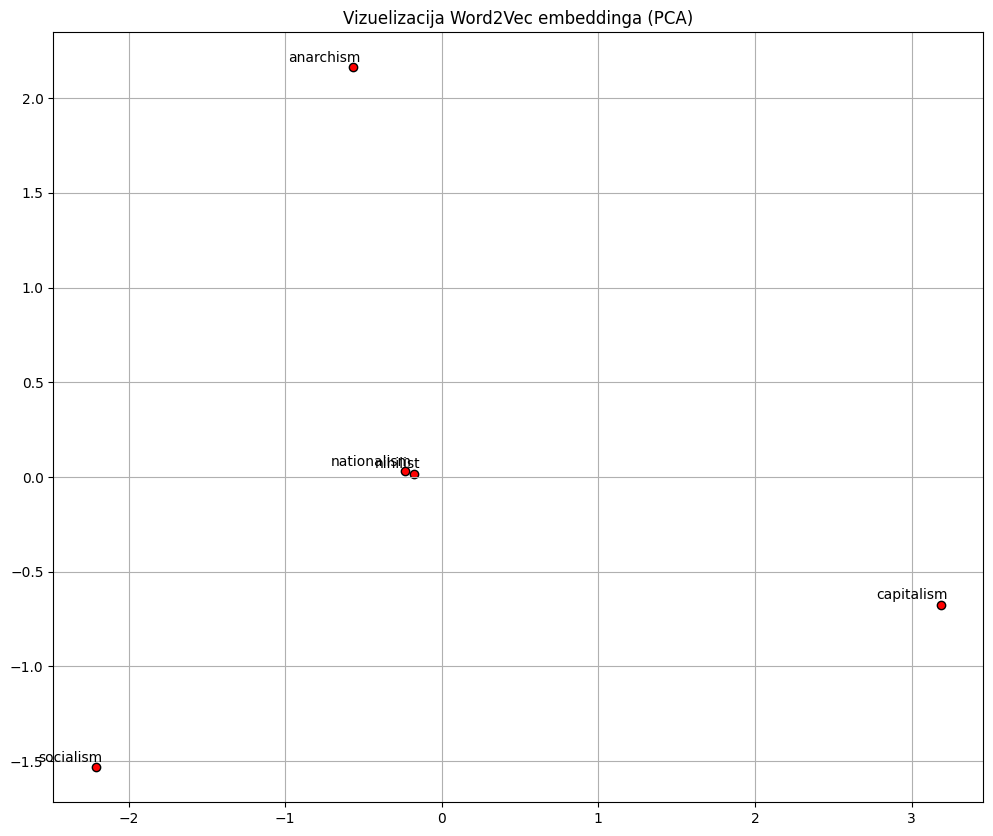

In [69]:
import matplotlib.pyplot as plt

def plot_pca(W, words_to_plot):
    # 1. Izdvajamo vektore za izabrane reči
    word_indices = [vocab[w] for w in words_to_plot if w in vocab]
    X = W[word_indices]
    
    # 2. PCA "peške" pomoću SVD (Singular Value Decomposition)
    # Centriramo podatke (oduzmemo prosek)
    X_centered = X - np.mean(X, axis=0)
    
    # SVD dekompozicija
    # U su leve singularne vektore, s su singularne vrednosti
    U, s, Vt = np.linalg.svd(X_centered)
    
    # Uzimamo prve dve glavne komponente (2D)
    X_pca = X_centered.dot(Vt.T[:, :2])
    
    # 3. Crtanje
    plt.figure(figsize=(12, 10))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], edgecolors='k', c='red')
    
    for i, word in enumerate(words_to_plot):
        if word in vocab:
            plt.annotate(word, xy=(X_pca[i, 0], X_pca[i, 1]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom')
    
    plt.title("Vizuelizacija Word2Vec embeddinga (PCA)")
    plt.grid(True)
    plt.show()

# Izaberi reči koje želiš da vidiš na grafiku
test_words = ['anarchism', 'nihilist', 'nationalism', 'socialism', 'capitalism', ]

plot_pca(W1, test_words)

FORWARD PASS    

In [25]:
def softmax(x):
    e = np.exp(x)
    return e / e.sum()

def forward_pass(word_id, W1, W2):
    # h: embedding za word (hidden layer)
    h = W1[word_id]
    # u: dot product (output)
    u = np.dot(h,W2)

    y_pred = softmax(u)

    return y_pred, h

BACKPROPAGATION

In [67]:
def backpropagation(error, h ,word_id, W1, W2, learning_rate):
    # gradijent za W2 (dimenzije cele matrice)
    dW2 = np.outer(h, error)
    # gradijent za W1 (dimenzije jednog vektora(reda) u matrici)
    dW1 = np.dot(error, W2.T)

    W2 -= learning_rate * dW2
    W1[word_id] -= learning_rate * dW1

    return W1, W2

Glavna petlja   

In [38]:
W1_copy = W1.copy()
W2_copy = W2.copy()

epochs = 100
learning_rate = 0.2
batch_size = 32
vocab_size = len(vocab)
vector_size = 10

for epoch in range(epochs):
    loss = 0
    np.random.shuffle(training_pairs)

    for i in range(0, len(training_pairs), batch_size):
        batch = training_pairs[i:i + batch_size]
        dW1_batch = np.zeros_like(W1_copy)
        dW2_batch = np.zeros_like(W2_copy)
        
        for center_word_id, pair_word_id in batch:
            y_pred, h = forward_pass(center_word_id, W1_copy, W2_copy)

            error = np.copy(y_pred)
            error[pair_word_id] -= 1

            dW2 = np.outer(h, error)
            dW1 = np.dot(error, W2_copy.T)

            dW2_batch += dW2
            dW1_batch[center_word_id] += dW1

            loss += -np.log(y_pred[pair_word_id] + 1e-10)

        W1_copy -= (learning_rate / len(batch)) * dW1_batch
        W2_copy -= (learning_rate / len(batch)) * dW2_batch

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs} | Loss: {loss:.4f}")

Epoch 10/100 | Loss: 35835.7683
Epoch 20/100 | Loss: 33649.4522
Epoch 30/100 | Loss: 32345.7707
Epoch 40/100 | Loss: 31456.2068
Epoch 50/100 | Loss: 30508.6700
Epoch 60/100 | Loss: 29487.8993
Epoch 70/100 | Loss: 28501.0346
Epoch 80/100 | Loss: 27589.9354
Epoch 90/100 | Loss: 26773.1546
Epoch 100/100 | Loss: 26068.8390


In [49]:
def softmax_batch(x):
    # x je matrica dimenzija (batch_size, vocab_size)
    
    # 2. Oduzimamo max i računamo eksponent
    exps = np.exp(x)
    
    # 3. Delimo svaki red sa sumom tog istog reda
    sum_per_row = np.sum(exps, axis=1, keepdims=True)
    
    return exps / sum_per_row

In [50]:
def forward_pass_batch(word_ids, W1, W2):
    # h više nije (10,), sada je (batch_size, 10)
    # NumPy automatski izvlači sve tražene redove iz W1 odjednom
    h = W1[word_ids]
    
    # u više nije (vocab_size,), sada je (batch_size, vocab_size)
    u = np.dot(h, W2)
    
    # Softmax mora da se izračuna za svaki red posebno
    y_pred = softmax_batch(u)
    
    return y_pred, h

In [51]:
def backpropagation_batch(error, h, W2, learning_rate):
    # dW2 se računa kao dot product, što automatski sumira gradijente za ceo batch
    # (vector_size, batch_size) @ (batch_size, vocab_size) -> (vector_size, vocab_size)
    dW2 = np.dot(h.T, error)
    
    # dW1 računa koliko svaki embedding u W1 treba da se promeni
    dW1 = np.dot(error, W2.T)
    
    return dW1, dW2

In [53]:
W1_copy = W1.copy()
W2_copy = W2.copy()

epochs = 100
learning_rate = 0.1
batch_size = 256
pairs = np.array(training_pairs)

for epoch in range(epochs):
    loss = 0
    np.random.shuffle(pairs)

    for i in range(0, len(pairs), batch_size):
        batch = pairs[i : i + batch_size]
        curr_batch = len(batch)
        c_ids, t_ids = batch[:, 0], batch[:, 1]

        # 1. Forward
        y_pred, h = forward_pass_batch(c_ids, W1_copy, W2_copy)

        # 2. Loss (vektorizovano uzimanje tačnih verovatnoća)
        loss += -np.sum(np.log(y_pred[np.arange(curr_batch), t_ids] + 1e-10))

        # 3. Error i Gradijenti
        error = y_pred
        error[np.arange(curr_batch), t_ids] -= 1

        dW2 = np.dot(h.T, error)
        dW1 = np.dot(error, W2_copy.T)

        # 4. Update
        W2_copy -= (learning_rate / curr_batch) * dW2
        np.add.at(W1_copy, c_ids, -(learning_rate / curr_batch) * dW1)

    print(f"Epoch {epoch + 1}/{epochs} | Loss: {loss:.4f}")

Epoch 1/100 | Loss: 1003582.9013
Epoch 2/100 | Loss: 1003577.0371
Epoch 3/100 | Loss: 1003567.2699
Epoch 4/100 | Loss: 1003548.4360
Epoch 5/100 | Loss: 1003509.5189


KeyboardInterrupt: 